# Layerwise Proxy Analysis

Purpose: select a model by GT rank (top or bottom) under a given task/search space, then compute per-layer FLOPs, SWAP, NASWOT, ZiCo-like grad ratio, and visualize. Text in charts is English; code comments in Chinese.

Steps:
1. Configure task/search space and rank (top-k or bottom-k).
2. Load TransNASBench API, sort architectures by GT, pick target.
3. Build model, run a small batch to collect per-layer metrics.
4. Plot per-layer metrics.

> Note: Layerwise ZiCo here uses per-layer mean(NSR) from a single backward pass; layerwise NASWOT uses per-ReLU logdet; SWAP counts unique sign patterns per layer; FLOPs uses fvcore by-module stats.


In [32]:
import sys
from pathlib import Path
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict


# 项目路径（notebook 下用 cwd）
CURRENT_DIR = Path.cwd()
ROOT_DIR = CURRENT_DIR.parent
NASLIB_ROOT = ROOT_DIR / "NASLib"

sys.path.insert(0, str(ROOT_DIR))
sys.path.insert(0, str(NASLIB_ROOT))

# 忽略冗余警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*unsupported.*")
warnings.filterwarnings("ignore", message=".*Unsupported.*")

from proxy_TransNAS.utils.load_model import (
    load_transbench_classes,
    load_transbench_api,
    make_train_loader,
    truncate_loader,
    set_op_indices_from_str,
    get_metric_name,
)
from proxy_TransNAS.proxies.flops import compute_flops  # 全局 FLOPs
from proxy_TransNAS.proxies.naswot import compute_naswot_score, network_weight_gaussian_init  # 全局 NASWOT
from proxy_TransNAS.proxies.swap import compute_swap_score  # 全局 SWAP
from proxy_TransNAS.proxies.zico import compute_zico_score, getgrad_safe  # 全局 ZiCo 与梯度收集
from fvcore.nn import FlopCountAnalysis  # 逐层 FLOPs



In [33]:
# 配置区域（根据需要修改）
TASK = "autoencoder"          # autoencoder / segmentsemantic / normal
SEARCH_SPACE = "macro"        # micro / macro
RANK_MODE = "top"             # top / bottom
RANK_K = 1                     # 第几名（1 表示第一名或最后一名）
DATA_ROOT = NASLIB_ROOT / "naslib" / "data"  # 数据根
BATCH_SIZE = 8                 # DataLoader batch，越小越省显存
MAXBATCH = 2                   # 只取前几个 batch
SEED = 42                      # 随机种子
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ENCODER_DECODER_SPLIT = None   # 手动指定分界层索引；None 时自动按层名包含"decoder"检测



In [34]:
# 准备数据与 API
torch.manual_seed(SEED)
TransMicro, TransMacro, graph_module = load_transbench_classes()
Metric = graph_module.Metric

data_root = Path(DATA_ROOT).resolve()
dataset_api = load_transbench_api(data_root, TASK)
api = dataset_api["api"]

# 选择架构列表
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransMicro(dataset=TASK, create_graph=True)
    arch_list = api.all_arch_dict["micro"]
else:
    ss = TransMacro(dataset=TASK, create_graph=True)
    arch_list = api.all_arch_dict["macro"]

# 根据 GT 排序，选取目标架构
metric_name = get_metric_name(TASK)
records = []
for arch_str in arch_list:
    gt = api.get_single_metric(arch_str, TASK, metric_name, mode="final")
    records.append((arch_str, gt))

df = pd.DataFrame(records, columns=["arch_str", "gt"])
df = df.sort_values(by="gt", ascending=False).reset_index(drop=True)
if RANK_MODE == "top":
    idx = RANK_K - 1
elif RANK_MODE == "bottom":
    idx = len(df) - RANK_K
else:
    raise ValueError("RANK_MODE must be top or bottom")
target = df.iloc[idx]
print(f"Selected arch #{idx+1}/{len(df)} (mode={RANK_MODE}): gt={target['gt']:.4f}")
print(target['arch_str'])



Selected arch #1/3256 (mode=top): gt=0.7488
64-221113-basic


In [35]:
# 构建 DataLoader（仅取少量 batch 以控制显存）
train_loader = make_train_loader(TASK, data_root, BATCH_SIZE, SEED)
train_batches = truncate_loader(train_loader, MAXBATCH)
assert len(train_batches) > 0, "DataLoader is empty"
inputs, labels = train_batches[0]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

# 辅助函数：重新构建模型
def build_model():  # 每次新建，避免权重被前一步修改
    g = ss.clone()
    g = set_op_indices_from_str(SEARCH_SPACE, g, target.arch_str)
    g.parse()
    return g.to(DEVICE)

model = build_model()  # 默认模型实例供后续复用



In [36]:
# 全局 proxy 分数（与运行脚本一致的实现）
# 每个 proxy 单独构建模型，避免权重修改互相影响

global_scores = {}

# FLOPs
m_flops = build_model()
global_scores["FLOPs"] = compute_flops(m_flops, train_batches, DEVICE)
del m_flops; torch.cuda.empty_cache()

# NASWOT
m_naswot = build_model()
global_scores["NASWOT"] = compute_naswot_score(m_naswot, train_batches, DEVICE)
del m_naswot; torch.cuda.empty_cache()

# SWAP
m_swap = build_model()
global_scores["SWAP"] = compute_swap_score(m_swap, train_batches, DEVICE)
del m_swap; torch.cuda.empty_cache()

# ZiCo
m_zico = build_model()
loss_fn = torch.nn.L1Loss() if TASK in ["autoencoder", "normal"] else (
    torch.nn.CrossEntropyLoss()
)
global_scores["ZiCo"] = compute_zico_score(m_zico, train_batches, loss_fn, DEVICE)
del m_zico; torch.cuda.empty_cache()

global_scores


{'FLOPs': 63563104256.0,
 'NASWOT': 132.8115404692918,
 'SWAP': 256.0,
 'ZiCo': 2.586360803246498}

In [37]:
# 逐层 FLOPs（使用 fvcore by_module，等价于全局 FLOPs 的分解）
model_layer = build_model()
model_layer.eval()
with torch.no_grad():
    flop_analyzer = FlopCountAnalysis(model_layer, inputs[:1])
    flop_analyzer.unsupported_ops_warnings(False)
    flop_analyzer.uncalled_modules_warnings(False)
    by_module = flop_analyzer.by_module()  # dict: module_name -> flops

flops_items = list(by_module.items())
flops_df = pd.DataFrame(flops_items, columns=["layer", "flops"])
flops_df.head()

del model_layer; torch.cuda.empty_cache()



In [38]:
# 逐层 NASWOT（与全局实现一致：ReLU 激活模式 logdet，但按层拆分）
import numpy.linalg as LA

model_nw = build_model()
model_nw.eval()
network_weight_gaussian_init(model_nw)  # 保持与全局计算一致
naswot_records = []  # (layer, logdet)

# 注册 hook 收集每个 ReLU 的激活符号矩阵
def make_hook(name):
    def hook(module, inp, out):
        x = inp[0]
        x = x.view(x.size(0), -1)
        s = (x > 0).float().cpu().numpy()
        K = s @ s.T + (1 - s) @ (1 - s.T)
        try:
            _, ld = LA.slogdet(K)
            naswot_records.append((name, float(ld)))
        except Exception:
            naswot_records.append((name, float("nan")))
    return hook

handles = []
for name, module in model_nw.named_modules():
    if isinstance(module, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU)):
        handles.append(module.register_forward_hook(make_hook(name)))

with torch.no_grad():
    _ = model_nw(inputs)

for h in handles:
    h.remove()

del model_nw; torch.cuda.empty_cache()

naswot_df = pd.DataFrame(naswot_records, columns=["layer", "naswot_logdet"])
naswot_df.head()



,layer,naswot_logdet
0,"None-edge(1,2).model.encoder.stem.2.ops.0",100.926231
1,"None-edge(1,2).model.encoder.layer0.0.conv_a.o...",92.612671
2,"None-edge(1,2).model.encoder.layer0.0.conv_b.o...",98.277351
3,"None-edge(1,2).model.encoder.layer0.1.conv_a.o...",97.874527
4,"None-edge(1,2).model.encoder.layer0.1.conv_b.o...",97.759583


In [39]:
# 逐层 SWAP（与全局一致的激活符号，但按层分别统计唯一模式）
model_sw = build_model()
model_sw.eval()

def make_swap_hook(name):
    def hook(module, inp, out):
        x = out  # 直接用输出
        x = x.view(x.size(0), -1)
        sign = torch.sign(x).cpu()
        unique_rows = torch.unique(sign, dim=0).shape[0]
        swap_records.append((name, int(unique_rows)))
    return hook

swap_records = []
handles = []
for name, module in model_sw.named_modules():
    if isinstance(module, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU)):
        handles.append(module.register_forward_hook(make_swap_hook(name)))

with torch.no_grad():
    _ = model_sw(inputs)

for h in handles:
    h.remove()

del model_sw; torch.cuda.empty_cache()

swap_df = pd.DataFrame(swap_records, columns=["layer", "swap_unique"])
swap_df.head()



,layer,swap_unique
0,"None-edge(1,2).model.encoder.stem.2.ops.0",8
1,"None-edge(1,2).model.encoder.layer0.0.conv_a.o...",8
2,"None-edge(1,2).model.encoder.layer0.0.conv_b.o...",8
3,"None-edge(1,2).model.encoder.layer0.1.conv_a.o...",8
4,"None-edge(1,2).model.encoder.layer0.1.conv_b.o...",8


In [40]:
# 逐层 ZiCo（与全局相同的梯度收集，逐层计算 log(NSR)）
model_zc = build_model()
model_zc.train()

# 选择损失
if TASK in ["autoencoder", "normal"]:
    loss_fn = torch.nn.L1Loss()
elif TASK == "segmentsemantic":
    loss_fn = torch.nn.CrossEntropyLoss()
else:
    loss_fn = torch.nn.CrossEntropyLoss()

# 遍历批次（与全局实现一致）
grad_dict = {}
for step_i, (xb, yb) in enumerate(train_batches):
    xb = xb.to(DEVICE)
    yb = yb.to(DEVICE)
    model_zc.zero_grad()
    logits = model_zc(xb)
    # 处理标签形状
    if yb.ndim == 4 and yb.shape[1] == 1:
        yb_ce = yb.squeeze(1)
    else:
        yb_ce = yb
    loss = loss_fn(logits, yb_ce)
    loss.backward()
    grad_dict = getgrad_safe(model_zc, grad_dict, step_i)
    model_zc.zero_grad(set_to_none=True)

zico_records = []
for name, grads in grad_dict.items():
    arr = np.array(grads)  # shape (steps, N)
    grad_std = np.std(arr, axis=0)
    nz = np.nonzero(grad_std)[0]
    if len(nz) == 0:
        zico_records.append((name, np.nan))
        continue
    grad_mean_abs = np.mean(np.abs(arr), axis=0)
    tmpsum = np.mean(grad_mean_abs[nz] / grad_std[nz])
    zico_records.append((name, float(np.log(tmpsum)) if tmpsum > 0 else np.nan))

zico_df = pd.DataFrame(zico_records, columns=["layer", "zico_log_nsr"])

# 清理
del model_zc
model = build_model()  # 重新构建默认模型供后续使用
torch.cuda.empty_cache()

zico_df.head()



,layer,zico_log_nsr
0,"None-edge(1,2).model.encoder.stem.0",1.617950
1,"None-edge(1,2).model.encoder.stem.2.ops.1",2.086547
2,"None-edge(1,2).model.encoder.layer0.0.conv_a.o...",1.999457
3,"None-edge(1,2).model.encoder.layer0.0.conv_b.o...",2.224733
4,"None-edge(1,2).model.encoder.layer0.0.downsamp...",2.557558


In [41]:
# 合并结果表（按层名对齐）
merged = flops_df.merge(naswot_df, on="layer", how="outer")
merged = merged.merge(swap_df, on="layer", how="outer")
merged = merged.merge(zico_df, on="layer", how="outer")
merged = merged.fillna(0)

# 层顺序调整：先 encoder，再其他，最后 decoder（按名字包含关键字）
# 解决 by_module 遍历导致 decoder 先出现的问题

def layer_sort_key(name: str):
    s = str(name)
    if "encoder" in s:
        return (0, s)
    if "decoder" in s:
        return (2, s)
    return (1, s)

merged = merged.assign(_order=merged["layer"].apply(layer_sort_key))
merged = merged.sort_values(by="_order").drop(columns=["_order"]).reset_index(drop=True)
merged.head()

# 记录全局分数，便于对比
print("Global proxy scores (same as scripts):")
for k, v in global_scores.items():
    print(f"{k}: {v:.4f}")



Global proxy scores (same as scripts):
FLOPs: 63563104256.0000
NASWOT: 132.8115
SWAP: 256.0000
ZiCo: 2.5864


In [42]:
# 调试：查看层名与自动分界检测
merged_seq = merged.reset_index(drop=True)
decoder_mask = merged_seq["layer"].astype(str).str.contains("decoder", case=False, na=False)
first_decoder_idx = int(decoder_mask.idxmax()) if decoder_mask.any() else None
print("Total layers:", len(merged_seq))
print("First decoder idx:" , first_decoder_idx,
      "name:" if first_decoder_idx is not None else "")
if first_decoder_idx is not None:
    print(merged_seq.loc[first_decoder_idx, "layer"])
else:
    print("(no layer contains 'decoder')")

print("\nPreview (index, layer, is_decoder):")
preview = merged_seq.assign(is_decoder=decoder_mask)
print(preview[["layer", "is_decoder"]].to_string())



Total layers: 237
First decoder idx: 181 name:
None-edge(1,2).model.decoder

Preview (index, layer, is_decoder):
                                                   layer  is_decoder
0                           None-edge(1,2).model.encoder       False
1                    None-edge(1,2).model.encoder.layer0       False
2                  None-edge(1,2).model.encoder.layer0.0       False
3           None-edge(1,2).model.encoder.layer0.0.conv_a       False
4       None-edge(1,2).model.encoder.layer0.0.conv_a.ops       False
5     None-edge(1,2).model.encoder.layer0.0.conv_a.ops.0       False
6     None-edge(1,2).model.encoder.layer0.0.conv_a.ops.1       False
7     None-edge(1,2).model.encoder.layer0.0.conv_a.ops.2       False
8           None-edge(1,2).model.encoder.layer0.0.conv_b       False
9       None-edge(1,2).model.encoder.layer0.0.conv_b.ops       False
10    None-edge(1,2).model.encoder.layer0.0.conv_b.ops.0       False
11    None-edge(1,2).model.encoder.layer0.0.conv_b.ops.1   

Auto-detected decoder split at layer #181: None-edge(1,2).model.decoder


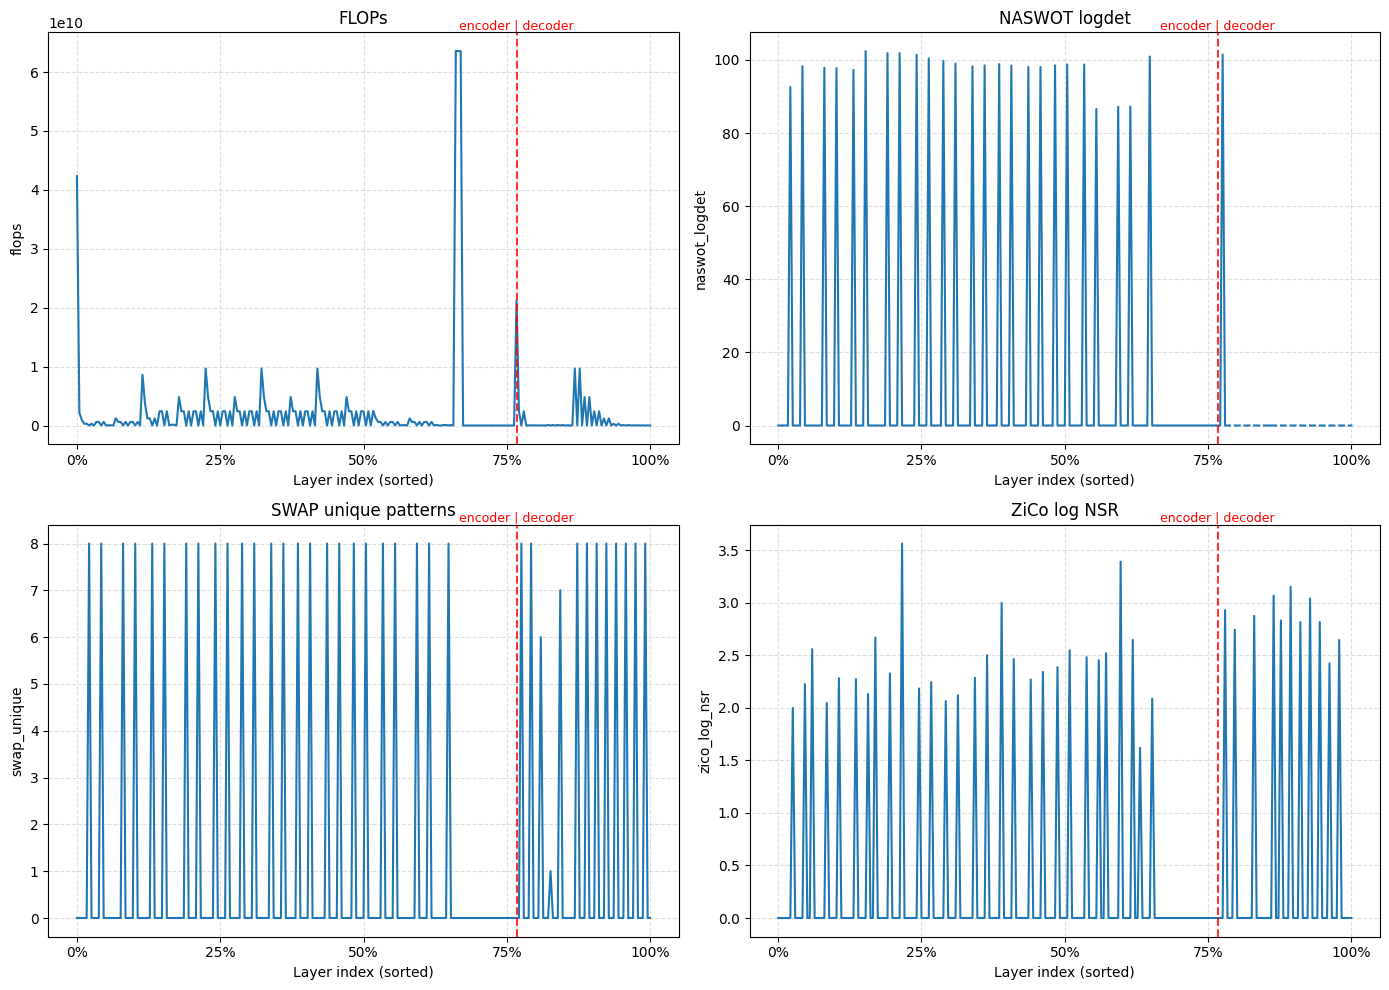

In [ ]:
# 可视化：四个子图分别展示 FLOPs / NASWOT / SWAP / ZiCo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_data = [
    (merged, "flops", "FLOPs"),
    (merged, "naswot_logdet", "NASWOT logdet"),
    (merged, "swap_unique", "SWAP unique patterns"),
    (merged, "zico_log_nsr", "ZiCo log NSR"),
]

# 自动检测分界：若未手动指定，就找第一个包含 "decoder" 的层名
split_to_use = ENCODER_DECODER_SPLIT
if split_to_use is None:
    merged_seq = merged.reset_index(drop=True)
    mask = merged_seq["layer"].astype(str).str.contains("decoder", case=False, na=False)
    if mask.any():
        split_to_use = int(mask.idxmax())
        print(f"Auto-detected decoder split at layer #{split_to_use}: {merged_seq.loc[split_to_use, 'layer']}")
    else:
        print("Warning: no layer name contains 'decoder'; no split line drawn")

for ax, (dfplot, col, title) in zip(axes, plot_data):
    dfplot_seq = dfplot.reset_index(drop=True)
    x = np.linspace(0, 1, len(dfplot_seq))  # 深度百分比
    ax.plot(x, dfplot_seq[col])  # 或 bar(x, ...)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.set_title(title)
    ax.set_xlabel("Layer index (sorted)")
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', alpha=0.4)

    # 针对非 FLOPs 图，抬高 y 轴下界以看清非零波动
    if col != "flops":
        vals = dfplot_seq[col].to_numpy()
        finite = vals[np.isfinite(vals)]
        nonzero = finite[finite != 0]
        if len(nonzero) > 0:
            ymin, ymax = nonzero.min(), nonzero.max()
            if ymin == ymax:
                ymin = ymin * 0.9 if ymin != 0 else -0.1
                ymax = ymax * 1.1 + 1e-6
            ax.set_ylim(bottom=ymin * 0.9, top=ymax * 1.05)

    # 标出 encoder/decoder 分界线
    if split_to_use is not None and len(dfplot_seq) > 1:
        split_idx = int(split_to_use)
        split_idx = max(0, min(split_idx, len(dfplot_seq) - 1))  # 防越界
        split_x = split_idx / (len(dfplot_seq) - 1)
        ax.axvline(split_x, color="red", linestyle="--", alpha=0.8)
        ax.text(split_x, ax.get_ylim()[1], "encoder | decoder", color="red",
                ha="center", va="bottom", fontsize=9, rotation=0)

plt.tight_layout()
plt.show()



In [44]:
summary = {
    "arch_str": target["arch_str"],
    "gt": float(target["gt"]),
    "num_layers_with_flops": int((merged.flops > 0).sum()),
    "num_layers_with_relu": int((merged.naswot_logdet != 0).sum()),
}
summary

{'arch_str': '64-221113-basic',
 'gt': 0.748816967010498,
 'num_layers_with_flops': 176,
 'num_layers_with_relu': 38}